In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

## Калибровка c `predict_proba`

In [2]:
X, y = make_classification(
    n_samples = 12000, # количество сэмплов
    n_features = 30, # количество функций
    n_informative = 20, # количество информ. функций
    n_redundant = 10, # количество избыточных функций
    weights = [.10, .1], # пропорции сэмплов для каждого класса
    random_state = 42) # генерация случайных чисел

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

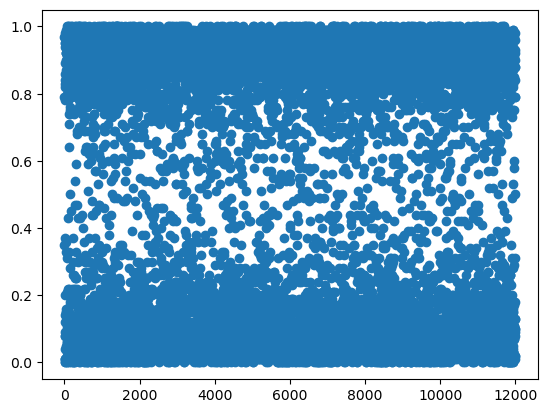

In [11]:
rf = RandomForestClassifier(n_jobs = -1)
rf.fit(X_train,y_train)
rf_fun = rf.predict_proba(X_train)
rf_fun
plt.scatter(range(len(rf_fun)),rf_fun[:,0]);

In [12]:
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf_isotonic = CalibratedClassifierCV(rf, cv=2, method="isotonic")
rf_sigmoid = CalibratedClassifierCV(rf, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (rf, "RF"),
    (rf_isotonic, "RF + Isotonic"),
    (rf_sigmoid, "RF + Sigmoid"),
]

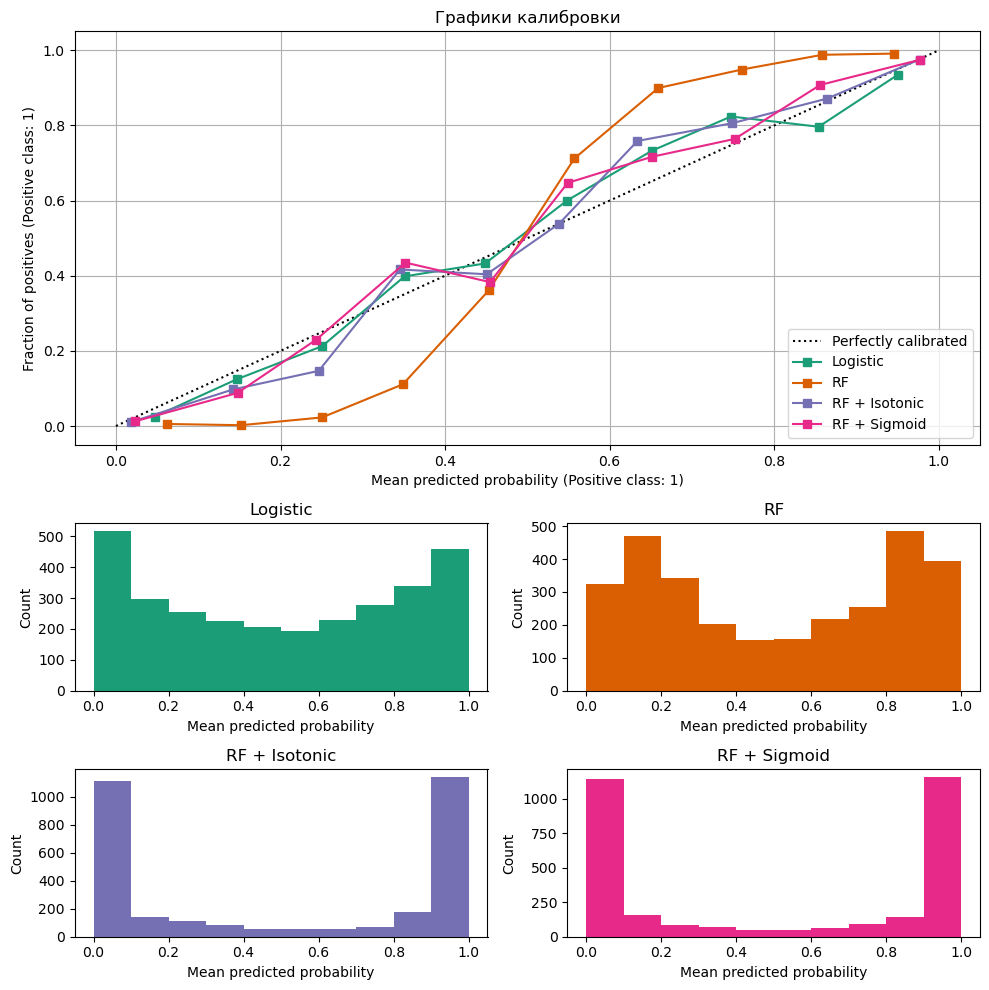

In [16]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        #strategy = 'quantile',
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Графики калибровки")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


Функция `brier_score_loss` вычисляет оценку Брайера для бинарных классов. 

Показатель Брайера — это функция оценки, которая измеряет точность вероятностных прогнозов. Он применим к задачам, в которых прогнозы должны назначать вероятности набору взаимоисключающих дискретных результатов.

Эта функция возвращает среднеквадратическую ошибку фактического результата $y\in \{0,1\}$ и прогнозируемую оценку вероятности `predict_proba`, выведенную по формуле:

$$BS = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}} - 1}(y_i - p_i)^2$$
 
`brier_score_loss` также находится в диапазоне от 0 до 1, и чем ниже значение (меньше среднеквадратическая разница), тем точнее прогноз.

Ниже пример использования этой функции.

Показатель Брайера можно использовать для оценки того, насколько хорошо откалиброван классификатор. Однако **более низкая потеря показателя Брайера не всегда означает лучшую калибровку**. Это связано с тем, что, по аналогии с разложением среднеквадратической ошибки на дисперсию и смещение, потерю оценки Брайера можно разложить как сумму потерь калибровки и потерь уточнения.

In [17]:
from collections import defaultdict
from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)

In [18]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.137532,0.427827,0.883774,0.808411,0.810033,0.809222
RF,0.072675,0.276268,0.980912,0.941728,0.940468,0.941098
RF + Isotonic,0.050749,0.190141,0.979275,0.932091,0.936455,0.934268
RF + Sigmoid,0.051314,0.183207,0.978555,0.931379,0.935117,0.933244
